# Model Selection

In [1]:
import numpy as np
import pandas as pd
import os

#plotting
import seaborn as sns
import matplotlib.pyplot as plt

#model evaluation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc

#models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier


# random state
SEED = np.random.seed(0)

Load Dataset

In [2]:
# PATHING ASSUMES "Processed Data" file is in the same directory as this file
path = os.path.abspath(r'Processed Data')
dataset = pd.read_csv(str(path))
dataset = dataset.drop('rawContent', axis=1)
dataset.head()


,replyCount,retweetCount,likeCount,quoteCount,links,media,mentionedUsers,hashtags,Party,Positive,Negative,Neutral,processed text
0,44.0,12.0,239.0,2.0,0,3,0,0,1,1,0,0,new year day seward overlooking harbor beautif...
1,19.0,4.0,22.0,1.0,0,0,0,1,1,1,0,0,happy newyear
2,9.0,5.0,19.0,0.0,0,0,0,0,1,1,0,0,championed provision strengthen alaska economy...
3,11.0,6.0,28.0,3.0,0,1,0,0,1,1,0,0,december senior appropriator helped write majo...
4,5.0,9.0,46.0,1.0,0,1,0,0,1,1,0,0,december congressman young legacy live many wa...


Vectorize Dataset for model training

In [3]:
# Vectorize the processed text column
X = dataset["processed text"]
td = TfidfVectorizer(max_features = 4500)
X = td.fit_transform(X.apply(lambda x: np.str_(x))).toarray()# v.fit_transform(df['Review'].apply(lambda x: np.str_(x)))

# concatenate the other relevant features to the vectorized processed text column
sub_dataset = dataset.drop(['Party', 'processed text'], axis=1)
X = np.concatenate((X, sub_dataset), 1)

# extract ground truth labels
y = dataset["Party"]


Train Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25,random_state = SEED)

In [5]:
def evaluate_model(clf, X, y, X_test, y_test):
    model = clf.fit(X, y)
    pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)

    #predicted probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]


    print('\n Accuracy: ', accuracy_score(y_test, pred))


    # Classification Report
    print("\nClassification Report ")
    print('======================================================')
    print(classification_report(y_test, pred))


    # Confusion Matrix
    print("\nConfusion Matrix ")
    print('======================================================')
    cm = confusion_matrix(y_test,pred)
    sns.heatmap(cm, annot=True, cmap='rocket')
    plt.xlabel('Predictions')
    plt.ylabel('Actual')
    plt.show()

    
    # ROC AUC curve
    print("\nROC AUC Curve ")
    print('======================================================')
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    sns.set_style('whitegrid')
    sns.set_palette('rocket_r')
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


    # Precision Recall Curve
    print("\nPrecision Recall Curve ")
    print('======================================================')
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
   
    sns.set_style('whitegrid')
    sns.set_palette('rocket_r')
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend()
    plt.show()

Grid Search Naive Bayes


 Accuracy:  0.8071700743258023

Classification Report 
              precision    recall  f1-score   support

           0       0.81      0.87      0.84    113665
           1       0.81      0.72      0.76     82902

    accuracy                           0.81    196567
   macro avg       0.81      0.79      0.80    196567
weighted avg       0.81      0.81      0.81    196567


Confusion Matrix 


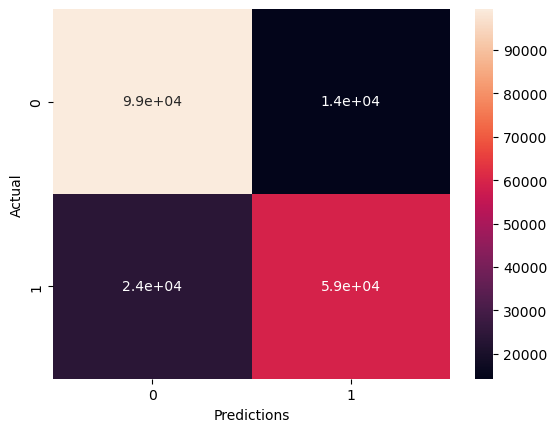


ROC AUC Curve 


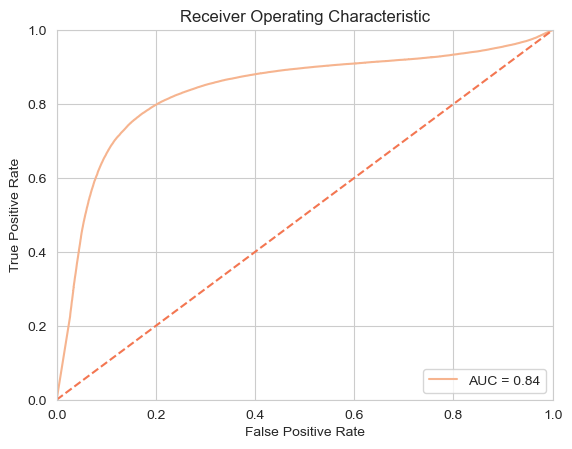


Precision Recall Curve 


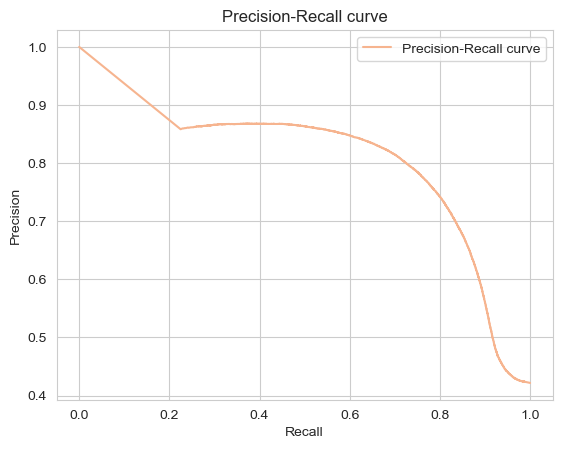

In [7]:
nb = MultinomialNB()

params = {'alpha': [1, 0.1, 0.01, 0.001, 0.0001]}

clf = GridSearchCV(nb,params)
evaluate_model(clf, X, y, X_test, y_test)

In [ ]:
# sgd = SGDClassifier()
# params = {
#     'loss': ['modified_huber'],
#     'penalty': ['elasticnet'],
#     'random_state': [SEED],
#     'early_stopping': [True]
# }

# clf = GridSearchCV(sgd,params)
# evaluate_model(clf, X, y, X_test, y_test)

KeyboardInterrupt: 

In [6]:
rf = RandomForestClassifier()
params  = {
    'n_estimators': [100,500,1000], 
    'max_depth' : [4,6,8]
}
clf = GridSearchCV(rf, params)
evaluate_model(clf, X, y, X_test, y_test)

: 

: 